**NYC Taxi Fare Prediction**

The project is to predict the fare prices from the given data, it is an regression task. The data for project is taken from kaggle https://www.kaggle.com/c/new-york-city-taxi-fare-prediction. I have uploaded to my S3 bucket in my aws and using it directly by importing using s3fs library.

Importing libraries

In [ ]:
import pandas as pd
import s3fs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import torch
import torch.nn as nn


In [ ]:
df = pd.read_csv('s3://charles-datasets/NYCTaxiFares.csv')

Sample of data

In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


The statistics of fare amount shows the data has few outliers.

In [ ]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
  r = 6371

  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])

  delta_phi = np.radians(df[lat2]-df[lat1])
  delta_lambda = np.radians(df[long2]-df[long1])

  a = np.sin(delta_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
  c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
  d = (r*c)

  return d

In [ ]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [ ]:
df['EDTdate'] =  pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime('%a')
df.head()


,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [ ]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [ ]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

In [ ]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [ ]:
cat_cols= ['Hour','AMorPM','Weekday']
cont_cols = ['pickup_latitude','dropoff_longitude', 'dropoff_latitude','pickup_longitude','passenger_count', 'dist_km']
y = ['fare_amount']

In [ ]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [ ]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [ ]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [ ]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [ ]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [ ]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [ ]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [ ]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

In [ ]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], axis=1)

In [ ]:
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [ ]:
cats = np.stack([df[c].cat.codes.values for c in cat_cols], axis=1)

In [ ]:
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [ ]:
cats = torch.tensor(cats, dtype=torch.int64)

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [ ]:
conts = np.stack([df[c].values for c in cont_cols], axis=1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5] 

tensor([[ 40.7305, -73.9755,  40.7447, -73.9924,   1.0000,   2.1263],
        [ 40.7406, -73.9742,  40.7441, -73.9901,   1.0000,   1.3923],
        [ 40.7511, -73.9601,  40.7662, -73.9941,   2.0000,   3.3268],
        [ 40.7564, -73.9712,  40.7482, -73.9905,   1.0000,   1.8641],
        [ 40.7342, -73.9060,  40.7431, -73.9910,   1.0000,   7.2313]])

In [ ]:
conts.type()

'torch.FloatTensor'

In [ ]:
y = torch.tensor(df[y].values, dtype=torch.float).reshape(-1,1)

In [ ]:
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [ ]:
cats.shape

torch.Size([120000, 3])

In [ ]:
conts.shape

torch.Size([120000, 6])

In [ ]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [ ]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

Embedding Categorical columns

In [ ]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [ ]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [ ]:
embeddingz = []

for i,e in enumerate(selfembeds):
  embeddingz.append(e(catz[:,i]))

embeddingz

[tensor([[ 1.0925,  0.7775,  0.2441, -0.3668,  0.0809,  1.2575, -1.0112, -1.1429,
          -0.7283, -0.9663,  1.1655, -0.7087],
         [ 1.1062, -1.0538, -0.2274, -0.5530,  0.0581,  0.6262, -1.1400,  0.1386,
           1.4490, -0.0892, -2.0983, -0.6256],
         [-0.6088,  0.6783, -0.5684, -0.3507,  0.7628,  1.1573,  0.2341,  0.8651,
           0.2732,  0.9121, -0.2044, -0.8776],
         [-0.9695,  1.0312, -0.7469, -0.5363,  1.7617, -1.3574, -0.1783,  0.9281,
           1.3052,  0.6879, -1.7658,  0.3739]], grad_fn=<EmbeddingBackward>),
 tensor([[ 1.8734],
         [ 1.8734],
         [ 1.8734],
         [-0.2717]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.0407, -0.1090, -0.5832, -0.0179],
         [ 0.6572,  1.3488,  0.3741,  0.1904],
         [ 0.6572,  1.3488,  0.3741,  0.1904],
         [ 0.3311,  1.7411, -2.0733,  0.0214]], grad_fn=<EmbeddingBackward>)]

In [ ]:
z = torch.cat(embeddingz, 1)
z

tensor([[ 1.0925,  0.7775,  0.2441, -0.3668,  0.0809,  1.2575, -1.0112, -1.1429,
         -0.7283, -0.9663,  1.1655, -0.7087,  1.8734,  0.0407, -0.1090, -0.5832,
         -0.0179],
        [ 1.1062, -1.0538, -0.2274, -0.5530,  0.0581,  0.6262, -1.1400,  0.1386,
          1.4490, -0.0892, -2.0983, -0.6256,  1.8734,  0.6572,  1.3488,  0.3741,
          0.1904],
        [-0.6088,  0.6783, -0.5684, -0.3507,  0.7628,  1.1573,  0.2341,  0.8651,
          0.2732,  0.9121, -0.2044, -0.8776,  1.8734,  0.6572,  1.3488,  0.3741,
          0.1904],
        [-0.9695,  1.0312, -0.7469, -0.5363,  1.7617, -1.3574, -0.1783,  0.9281,
          1.3052,  0.6879, -1.7658,  0.3739, -0.2717,  0.3311,  1.7411, -2.0733,
          0.0214]], grad_fn=<CatBackward>)

In [ ]:
selfemdrop = nn.Dropout(.4)

In [ ]:
z = selfemdrop(z)
z

tensor([[ 1.8209,  0.0000,  0.4069, -0.0000,  0.1348,  2.0959, -1.6853, -1.9048,
         -1.2138, -1.6105,  0.0000, -0.0000,  3.1224,  0.0678, -0.1816, -0.0000,
         -0.0298],
        [ 1.8436, -1.7564, -0.3790, -0.0000,  0.0968,  1.0436, -1.9000,  0.2310,
          0.0000, -0.1487, -0.0000, -0.0000,  0.0000,  0.0000,  2.2479,  0.6236,
          0.0000],
        [-0.0000,  0.0000, -0.0000, -0.5845,  1.2713,  0.0000,  0.0000,  1.4418,
          0.0000,  0.0000, -0.3407, -1.4627,  3.1224,  1.0954,  0.0000,  0.6236,
          0.3174],
        [-0.0000,  1.7186, -0.0000, -0.0000,  2.9362, -0.0000, -0.2972,  1.5469,
          2.1754,  0.0000, -2.9430,  0.6232, -0.0000,  0.5519,  0.0000, -3.4555,
          0.0000]], grad_fn=<MulBackward0>)

Building a Regression Model

In [ ]:
class TabularModel(nn.Module):
  def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
    
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_cont)

    layerlist = []
    n_emb = sum(nf for ni,nf in emb_szs)
    n_in = n_emb + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in, i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i

    layerlist.append(nn.Linear(layers[-1], out_sz))

    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_cat, x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:,i]))

    x = torch.cat(embeddings, axis=1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], axis=1)
    x = self.layers(x)

    return x


In [ ]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [ ]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Loss Function

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Spliting the data

In [ ]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
len(cat_train)

48000

In [ ]:
len(cat_test)

12000

Training the data

In [ ]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
  i+=1
  y_pred = model(cat_train, cont_train)
  loss = torch.sqrt(criterion(y_pred, y_train))
  losses.append(loss)

  if i%25==1:
    print(f'epoch: {i:3} loss: {loss.item(): 10.8f}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(f'epoch: {i:3} loss: {loss.item():10.8f}')
print(f'nDuartion: {time.time() - start_time:.0f} seconds')

epoch:   1 loss:  12.56703854
epoch:  26 loss:  10.90517616
epoch:  51 loss:  10.23300171
epoch:  76 loss:  9.74051476
epoch: 101 loss:  9.19800663
epoch: 126 loss:  8.43523312
epoch: 151 loss:  7.42202473
epoch: 176 loss:  6.25717497
epoch: 201 loss:  5.06305361
epoch: 226 loss:  4.21228933
epoch: 251 loss:  3.84753275
epoch: 276 loss:  3.75968671
epoch: 300 loss: 3.67729902
nDuartion: 333 seconds


ploting the losses

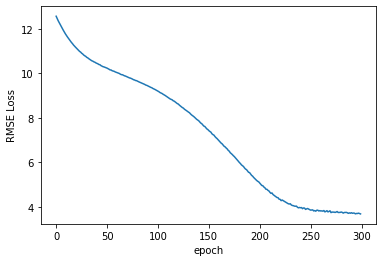

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.61987185


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [ ]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   2.8141   2.9000   0.0859
 2.  20.8517   5.7000  15.1517
 3.   8.6853   7.7000   0.9853
 4.  13.0069  12.5000   0.5069
 5.   5.5449   4.1000   1.4449
 6.   7.6447   5.3000   2.3447
 7.   6.1117   3.7000   2.4117
 8.  16.6877  14.5000   2.1877
 9.   6.1046   5.7000   0.4046
10.  11.7829  10.1000   1.6829
11.   5.2339   4.5000   0.7339
12.   7.2134   6.1000   1.1134
13.   7.7220   6.9000   0.8220
14.  13.9898  14.1000   0.1102
15.   4.6884   4.5000   0.1884
16.  32.3988  34.1000   1.7012
17.   2.7988  12.5000   9.7012
18.   2.4183   4.1000   1.6817
19.   8.4252   8.5000   0.0748
20.   3.5997   5.3000   1.7003
21.  15.6007  11.3000   4.3007
22.  11.4210  10.5000   0.9210
23.  18.2723  15.3000   2.9723
24.  18.6214  14.9000   3.7214
25.  44.9617  49.5700   4.6083
26.   2.8409   5.3000   2.4591
27.   8.0403   3.7000   4.3403
28.   8.7246   6.5000   2.2246
29.  14.0488  14.1000   0.0512
30.   5.0700   4.9000   0.1700
31.   5.2063   3.7000   1.5063
32.  45.